##### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from scipy.integrate import solve_ivp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy.sparse import csr_matrix, save_npz, load_npz
from scipy.interpolate import interp1d
import numpy as np
from skimage.filters import threshold_otsu
from scipy.ndimage import label, center_of_mass
import time
import pickle
import cv2
import torch

# os.chdir('/Users/gregoire/Codes/project_theoretical_neuro')
if not os.path.exists('data'):
    os.mkdir('data')

os.getcwd()

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

## Model bone

#### Tiling angles

In [ ]:
def deterministic_theta_tiling(n):
    thetas = [0, np.pi/2, np.pi, -np.pi/2] # W N E S
    theta_pref = torch.tensor([thetas*(n//4), thetas[2:] + thetas*(n//4 - 1) + thetas[:2]]*(n//2))
    return theta_pref


def random_theta_tiling(n):
    thetas = torch.tensor([0, np.pi/2, np.pi, -np.pi/2]) # W N E S
    dir_pref = np.random.randint(0, 4, n*n)
    theta_pref = thetas[[dir_pref]]
    return theta_pref.reshape(n, n)

#### Solvers

In [2]:
def euler_solve(derS, dt, v, s_0, device='cpu'):
    S = torch.zeros((len(v), n*n)).to(device)
    S[0] = s_0
    v_t = lambda t: v[t]
    print('Simulating with euler method')
    t0 = time.time()
    for t in tqdm(range(len(v[:-1]))):
        S[t + 1] = S[t] + dt*derS(t, S[t], v_t)
        
    return S

def rk45_solve(derS, dt, v, s_0):
    raise NotImplementedError('Rk45 not implemented yet on gpu, try euler')
    
    """
    v = v.T
    t_array = np.arange(0, v.shape[1], 1)*dt
    v_interp = interp1d(t_array, v, axis=1, kind="linear", fill_value="extrapolate") # TODO : interpolation on GPU
    v_t = lambda t: v_interp(t)
    print('Solving using rk45')
    T = v.shape[1]*dt
    S = solve_ivp(derS, t_span=(0, T), y0=s_0, t_eval=t_array, args = (v_t,), method="RK45")
    return S['y'].T
    """

#### Simulator

In [3]:
def norm2(x):
    return torch.sum(x**2, -1)
    
def w0(x, a, gamma, beta):
    xx = norm2(x)
    return a*(torch.exp(-gamma*xx)-torch.exp(-beta*xx))


def W_mat(n, vec_pref, periodic, a, gamma, beta, l, load=True, save=True, sparsity_threshold=0., device='cpu'):
    fname = f"data/Wmat_n={n}_a={a}_gamma={gamma}_beta={beta}_l={l}_sparsity = {sparsity_threshold}"+ "_a"*(1-periodic)+ "periodic.npz"

    if load and os.path.exists(fname):
        print(f"Loading pre-computed matrix at {fname}")
        W = torch.load(fname)
        print('matrix loaded')
        return torch.tensor(W).to(device)

    print('building matrix...')
    neuron_indexes = torch.arange(0, n*n, 1).to(device)
    x_loc = neuron_indexes%n
    y_loc = neuron_indexes//n
    
    X = torch.stack([x_loc, y_loc], 1)
    X_diff = torch.abs(X[:, torch.newaxis, :] - X[torch.newaxis, :, :] - l * vec_pref[:, torch.newaxis, :]) # distance h, v entre tous les points + shift

    if periodic : 
        X_diff =  torch.minimum(X_diff, n-X_diff)
        
    W = w0(x=X_diff.reshape(-1, X.shape[-1]), a=a, beta=beta, gamma=gamma).reshape(n*n, n*n).to(device)
    '''
    if sparsity_threshold > 0:
        W = W * (W<= sparsity_threshold*W.mean())

    W = csr_matrix(W)
    '''
    if save :
        torch.save(W.cpu(), fname)
    return W


SOLVERS = {'euler': euler_solve, 'rk45': rk45_solve}

def simulate_trajectory(v, args, s_0=None,
                        random_tiling=False, loadW=True, saveW=True, save=True, savepath = None, sparsity_threshold = 0, solver = euler_solve,
                       device = 'cpu'):
    
    if random_tiling: 
        theta_pref = random_theta_tiling(args['n'])
    else :
        theta_pref = deterministic_theta_tiling(args['n'])
        
    vec_pref = torch.stack([torch.cos(theta_pref.flatten()), torch.sin(theta_pref.flatten())], 1).to(device) # prefered direction unit vector
    
    if args['periodic'] : 
        A = 1
    else : 
        raise NotImplementedError('Aperiodic case not implemented yet !')
        # A = torch.tensor(( XX < R - dr ) * 1 + ( XX >= R - dr ) * np.exp( -a0 * (XX - R + dr)**2 / dr**2 )).to(device)
        
    def B(v):
        return A * (1 + args['alpha'] * vec_pref@v)

    if s_0 is None :
        s_0 = 00.1*torch.rand(n*n).to(device)
    
    W = W_mat(args['n'], vec_pref, args['periodic'], args['a'], args['gamma'], args['beta'], args['l'], load=loadW, save=saveW, sparsity_threshold = args['sparsity_threshold'], device=device)
    
    def derS(t, s, v_t):
        input_ = W @ s + B(v_t(t))
        return (1/args['tau']) * (-s + input_ * (input_ > 0))

    v = v.to(device).float()
    s_0 = s_0.to(device).float()

    S = SOLVERS[args['solver']](derS, args['dt'], v, s_0, device=device)

    if save:
        if savepath is None :
            savepath = "data/trajectory_" + "_".join([k + str(args[k]) for k in args.keys()]) + ".npy"
        torch.save(S, savepath)
        
    return S.cpu(), W.cpu()

#### Args

In [4]:
lambda_net = 15 # approximate number of neurons between two blob centers
e = 1.15 # controls the distance between inner limit and upper limit of the inhibitory surround, recommend 1.25 for n=32, 1.05 for n=128

n = 40

args = {'tau':1E-2, # time constant of the network
        'alpha':0.2, # strength of the speed input
        'gamma': e*3/(lambda_net**2), # outer limit of the inhib surround
        'beta': 3/(lambda_net**2), # inner limit of the inhib surround
        'periodic':True,
        'a':1.5, # if a > 1, close surround of cells is activatory
        'l':1, # spatial shift size of the center of the inhibitory surround
        'n':n, 
        'sparsity_threshold':0.,
        'solver':'euler',
        'dt':1E-4
        }

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

NameError: name 'torch' is not defined

## Plotting and analysis

#### Dimensionality reduction 

In [185]:
import torch

def pca_torch_gpu(data, num_components):
    device = data.device
    centered_data = data - torch.mean(data, dim=0, keepdim=True)

    cov_matrix = torch.mm(centered_data.T, centered_data) / (data.size(0) - 1)
    eigvals, eigvecs = torch.linalg.eigh(cov_matrix)

    sorted_indices = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]

    components = eigvecs[:, :num_components]
    explained_variance = eigvals[:num_components]

    projected_data = torch.mm(centered_data, components)

    return projected_data, explained_variance, components


def simple_4d(traces, plot = True, basis = None, eigval=None, dpi=100):
    
    if basis is None : 
        projections, exp_var, basis = pca_torch_gpu(traces, 4)

    else:
        projections = traces@basis[:, :4]

    trajectory = projections.cpu().numpy()
    
    if plot : 
        fig = plt.figure(figsize = (6, 3), dpi = 150)
        ax = fig.add_subplot(projection='3d')
        p = ax.scatter(xs = trajectory[:, 0].astype('float'), ys = trajectory[:, 1].astype('float'), zs = trajectory[:, 2].astype('float'), c = trajectory[:, 3].astype('float'), cmap=plt.cm.magma, s=1)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])    
        cbar = fig.colorbar(p, ax=ax, pad=0.15, label='PC4')
        cbar.set_ticks([])
        plt.tight_layout()
        plt.show()
        
    return projections, exp_var, basis

#### Blob tracker

In [186]:
def blob_center(traces, n_candidates = 8, smoothing = 2, verb=False):
    t=1 if traces.ndim ==1 else len(traces)
    n = int(np.sqrt(traces.shape[-1]))
    
    vid = gaussian_filter(traces.reshape(-1, n, n), sigma=1, axes=(-1, -2))
    thresholds = np.array([threshold_otsu(img) for img in vid]) 
    binary_images = vid > thresholds[:, None, None] 


    labeled_images = np.zeros_like(binary_images, dtype=int)

    N= []
    if verb:
        print('labeling blobs')
        
    for i in range(len(binary_images)):
        labeled, num_features = label(binary_images[i])
        labeled_images[i] = labeled
        N.append(num_features)

    m = np.max(N)
    if verb:
        print(f'detected less than {m} blobs per frame')
        print(f'computing blob centers')
    centers = np.stack([np.array(center_of_mass(binary_images[i], labeled_images[i], range(1, m+1)))
           for i in range(vid.shape[0])])

    centers = centers[:, :, [1, 0]] # need to transpose x, y for some reason
    dist = np.linalg.norm(centers-n/2, axis=2)
    pred = centers[[np.arange(0, t, 1)], np.argmin(dist, axis = 1), :].squeeze()
    
    if verb:
        print(f'done')
    return pred, centers

def integrate_velocity_from_blob(center_coords):
    v = np.diff(center_coords, axis=0)
    return v

#### Plot frames

In [187]:
def plot_10_frames(traj, dt, plot_center = True, plot_centers=True):
    n = int(np.sqrt(len(traj[0])))
    fig, ax = plt.subplots(2, 5, figsize = (20, 10))
    times = np.linspace(0, len(traj) -1, 10, dtype = 'int')
    for k, t in enumerate(times):
        ax[k//5, k%5].imshow(traj[t, :].reshape(n, n))
        ax[k//5, k%5].set_title(f"{t*1000*dt} ms")
        if plot_center:
            ax[k//5, k%5].axvline(n/2, c='red', lw=0.8)
            ax[k//5, k%5].axhline(n/2, c='red', lw=0.8)
        if plot_centers:
            center_coords, p = blob_center(traj[t, :], n_candidates=5, smoothing = 0, verb=False)
            ax[k//5, k%5].scatter(p[0, :, 0], p[0, :, 1], c='red', marker='x')
        
    plt.show()

#### Movie

In [188]:
def rec_movie(traces, fpath, dt, speed_ratio=1/4, cmap='magma'):
# Paramètres de la vidéo
    fps = int(1/dt) * speed_ratio  # frames per second
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec

    n = int(np.sqrt(traces.shape[1]))
    fig, ax = plt.subplots()
    ax.axis('off')  
    plt.tight_layout()

    generated_images = []

    print('generating movie...')
    for frame in tqdm(traces.reshape(-1, n, n)):
        ax.imshow(frame, cmap=cmap, interpolation=None) 
        fig.canvas.draw() 

        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # Format (hauteur, largeur, 4)
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2BGR) 
        
        generated_images.append(image)

        plt.close(fig)  

    height, width, _ = generated_images[0].shape
    video_writer = cv2.VideoWriter(fpath, fourcc, fps, (width, height))

    for img in generated_images:
        video_writer.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for OpenCV

    video_writer.release()
    print(f"Video recorded at {fpath}")


## Spontaneous formation of the triangular lattice at v=0

In [189]:
fig_path = 'figures/'

if not os.path.exists(fig_path):
    os.mkdir('figures')

building matrix...
Simulating with euler method


100%|██████████| 499/499 [00:00<00:00, 2901.97it/s]


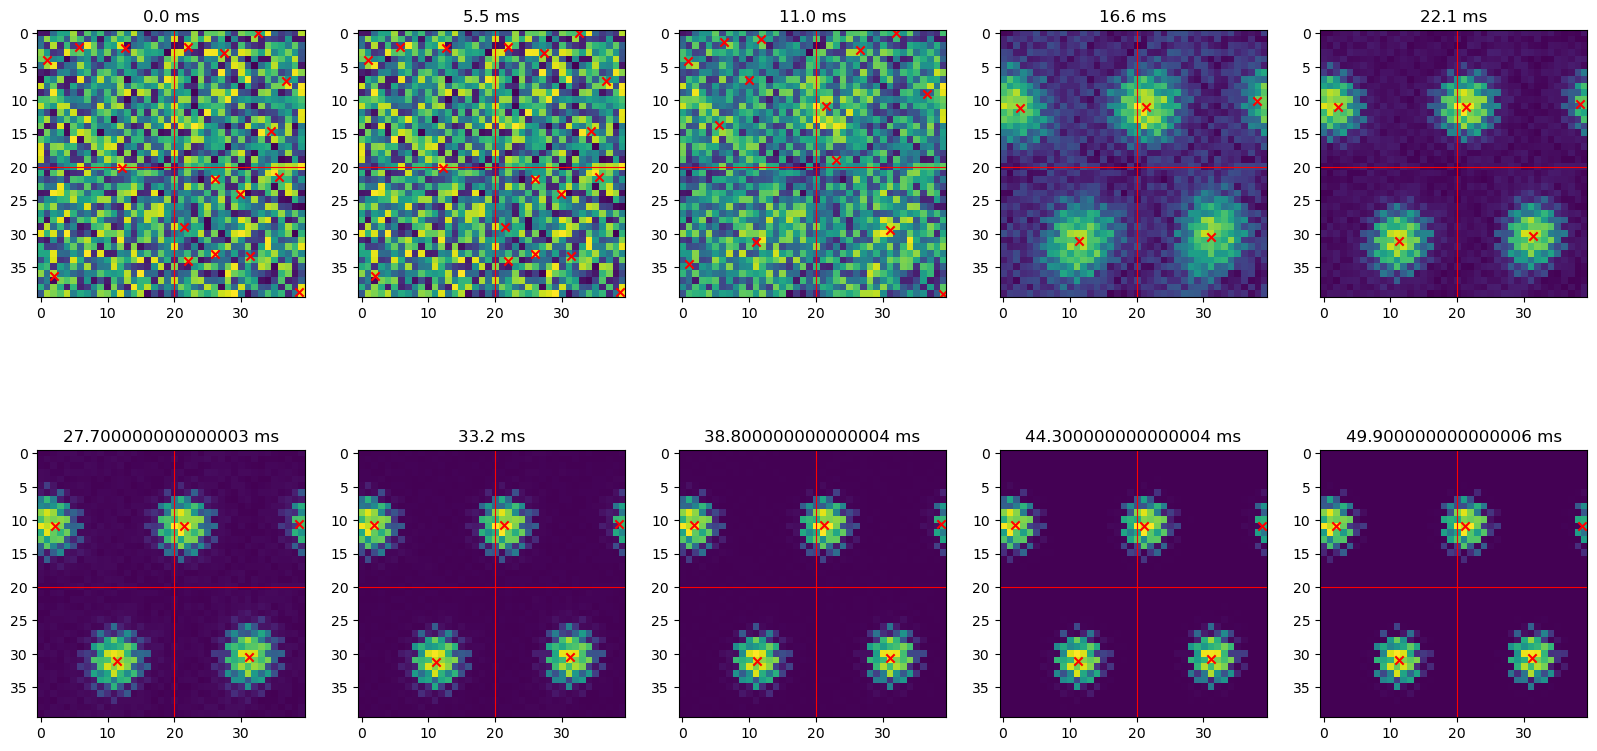

In [190]:
T = 0.05
dt = args['dt']
num_steps = int(T/dt)
v = torch.zeros((num_steps, 2))
traces, w = simulate_trajectory(v, args, random_tiling=False, loadW=False, saveW=True, device=device, )
plot_10_frames(traces, dt)

# rec_movie(traces, fpath=fig_path + 'pattern_formation.mp4', dt=dt, speed_ratio = 1/200)
eq_state = traces[-1]

### Heal the formed pattern

/tmp/ipykernel_882/1415829333.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  W = torch.load(fname)
/tmp/ipykernel_882/1415829333.py:16: UserWarning: To copy construct 

Loading pre-computed matrix at data/Wmat_n=40_a=1.5_gamma=0.015333333333333332_beta=0.013333333333333334_l=1_sparsity = 0.0periodic.npz
matrix loaded
Simulating with euler method


100%|██████████| 499/499 [00:03<00:00, 151.27it/s]


Loading pre-computed matrix at data/Wmat_n=40_a=1.5_gamma=0.015333333333333332_beta=0.013333333333333334_l=1_sparsity = 0.0periodic.npz
matrix loaded
Simulating with euler method


100%|██████████| 499/499 [00:04<00:00, 100.12it/s]


Loading pre-computed matrix at data/Wmat_n=40_a=1.5_gamma=0.015333333333333332_beta=0.013333333333333334_l=1_sparsity = 0.0periodic.npz
matrix loaded
Simulating with euler method


100%|██████████| 499/499 [00:05<00:00, 96.35it/s] 


Loading pre-computed matrix at data/Wmat_n=40_a=1.5_gamma=0.015333333333333332_beta=0.013333333333333334_l=1_sparsity = 0.0periodic.npz
matrix loaded
Simulating with euler method


100%|██████████| 499/499 [00:05<00:00, 97.69it/s] 


Loading pre-computed matrix at data/Wmat_n=40_a=1.5_gamma=0.015333333333333332_beta=0.013333333333333334_l=1_sparsity = 0.0periodic.npz
matrix loaded
Simulating with euler method


100%|██████████| 499/499 [00:04<00:00, 100.17it/s]


Loading pre-computed matrix at data/Wmat_n=40_a=1.5_gamma=0.015333333333333332_beta=0.013333333333333334_l=1_sparsity = 0.0periodic.npz
matrix loaded
Simulating with euler method


100%|██████████| 499/499 [00:04<00:00, 111.18it/s]


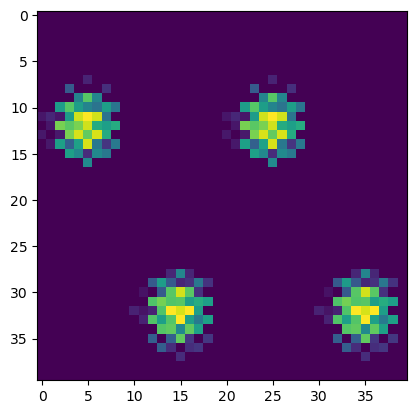

In [191]:
v = torch.zeros((num_steps, 2))
T = 0.25
traces, w = simulate_trajectory(v, args, s_0 = eq_state, random_tiling=False, loadW=True, saveW=True)
eq_state = traces[-1]

angles = [0, np.pi/5, np.pi/2, -np.pi/5]
for a in angles:
    v = 0.8 * torch.tensor([np.cos(a), np.sin(a)]) * torch.ones_like(v)
    traces, w = simulate_trajectory(v, args, s_0 = eq_state, random_tiling=False, loadW=True, saveW=True)
    eq_state = traces[-1] 

v = torch.zeros((num_steps, 2))
T = 0.25
traces, w = simulate_trajectory(v, args, s_0 = eq_state, random_tiling=False, loadW=True, saveW=True)
eq_state = traces[-1]

plt.imshow(eq_state.reshape(n,n))

### Rectilign movement / neural trajectories

/tmp/ipykernel_882/1415829333.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  W = torch.load(fname)
/tmp/ipykernel_882/1415829333.py:16: UserWarning: To copy construct 

Loading pre-computed matrix at data/Wmat_n=40_a=1.5_gamma=0.015333333333333332_beta=0.013333333333333334_l=1_sparsity = 0.0periodic.npz
matrix loaded
Simulating with euler method


100%|██████████| 15999/15999 [04:57<00:00, 53.78it/s]


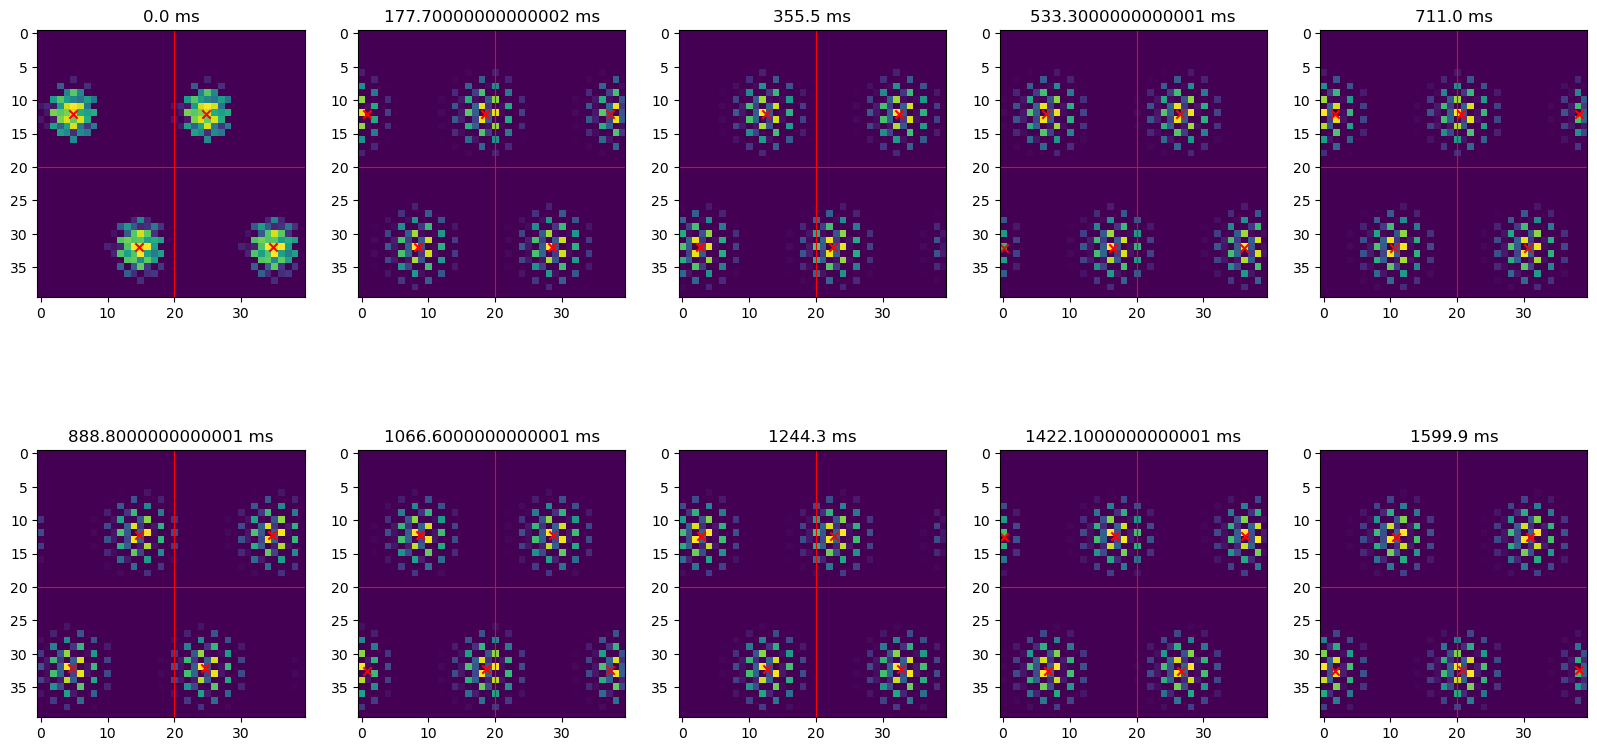

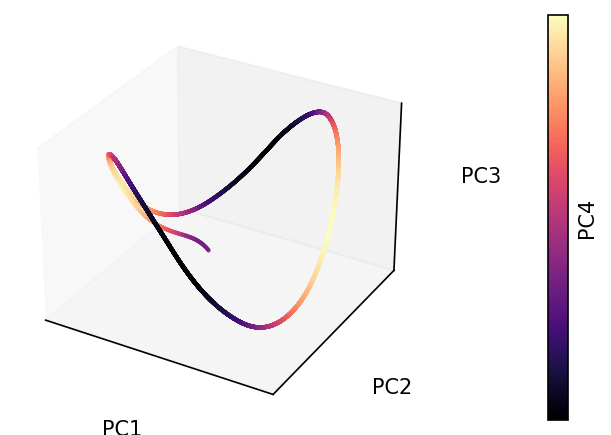

ValueError: too many values to unpack (expected 2)

In [192]:
T = 1.6 # s
dt = 1e-4
num_steps = int(T/dt)

v = torch.zeros((num_steps, 2))
v[:, 0] = 3

traces, w = simulate_trajectory(v, args, s_0 = eq_state, random_tiling=False, loadW=True, saveW=True)
plot_10_frames(traces, dt)

reduced, eigval = simple_4d(traces)

plt.bar([k for k in range(4)], 100*eigval[:4]/np.sum(eigval))
plt.bar(5, 100*eigval[:4].sum()/np.sum(eigval))
plt.ylim(-1, 101)
plt.show()

(array([113, 565]),)
[[-19.88         0.1       ]
 [-19.81877551   0.05102041]]


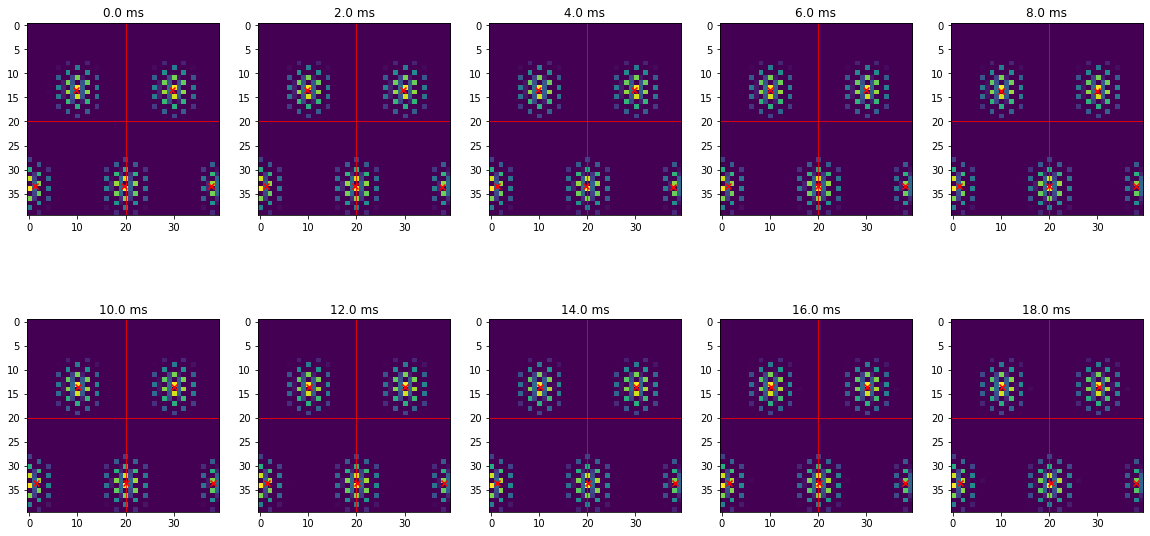

In [704]:
center_coords, blobs = blob_center(traces)
v = np.diff(center_coords, axis=0)
print(np.where(np.linalg.norm(v, axis = 1) > 1))
print(v[np.where(np.linalg.norm(v, axis = 1) > 1)])

plot_10_frames(traces[110:120], dt=dt)

In [703]:
center_coords[113], center_coords[114]

(array([29.88, 13.5 ]), array([10. , 13.6]))

Loading pre-computed matrix at data/Wmat_n=40_a=1.5_gamma=0.034499999999999996_beta=0.03_l=0.1_sparsity = 0.0periodic.npz
matrix loaded
Solving using rk45


IndexError: tuple index out of range

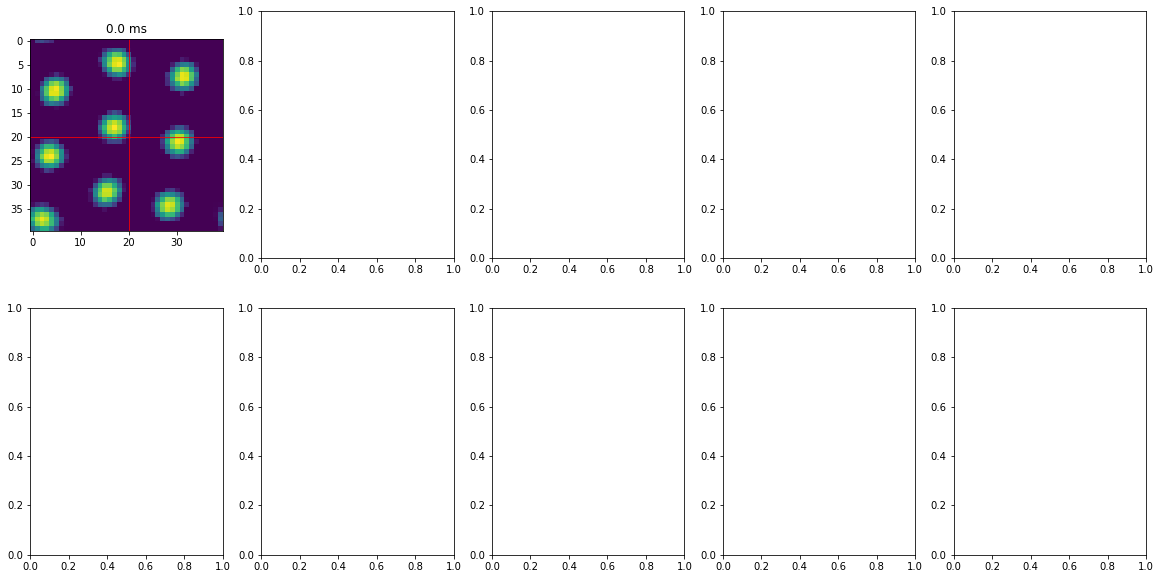

In [238]:
T = 1.6 # s
dt = 1e-2
num_steps = int(T/dt)

v = np.zeros((num_steps, 2))
v[:, 1] = 2

traj, w = simulate_trajectory(v, dt, s_0 = eq_state, **args)
plot_10_frames(traj, dt)

reduced, eigval = simple_4d(traj)

plt.bar([k for k in range(4)], 100*eigval[:4]/np.sum(eigval))
plt.bar(5, 100*eigval[:4].sum()/np.sum(eigval))
plt.ylim(-1, 101)
plt.show()

Loading pre-computed matrix at data/Wmat_n=40_a=1.5_gamma=0.015333333333333332_beta=0.013333333333333334_l=0.1_sparsity = 0.0periodic.npz
matrix loaded
Solving using rk45


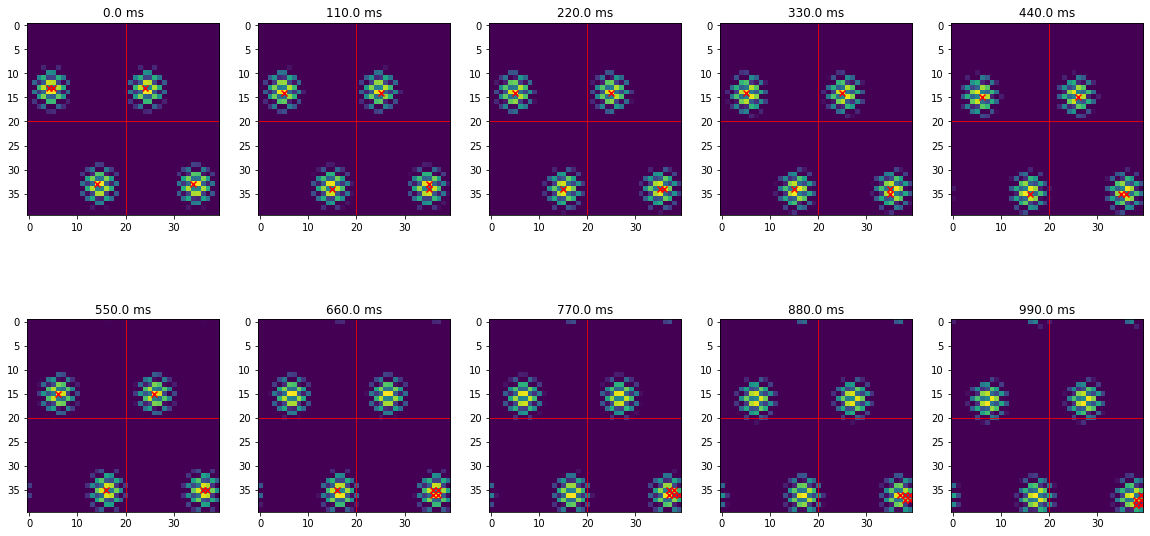

/var/folders/6_/x78gg4gd7cz_rjvgh5qr_xy80000gs/T/ipykernel_772/3066771667.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  p = ax.scatter(xs = reduced[:, 0].astype('float'), ys = reduced[:, 1].astype('float'), zs = reduced[:, 2].astype('float'), c = reduced[:, 3].astype('float'), cmap=plt.cm.magma, s=1)


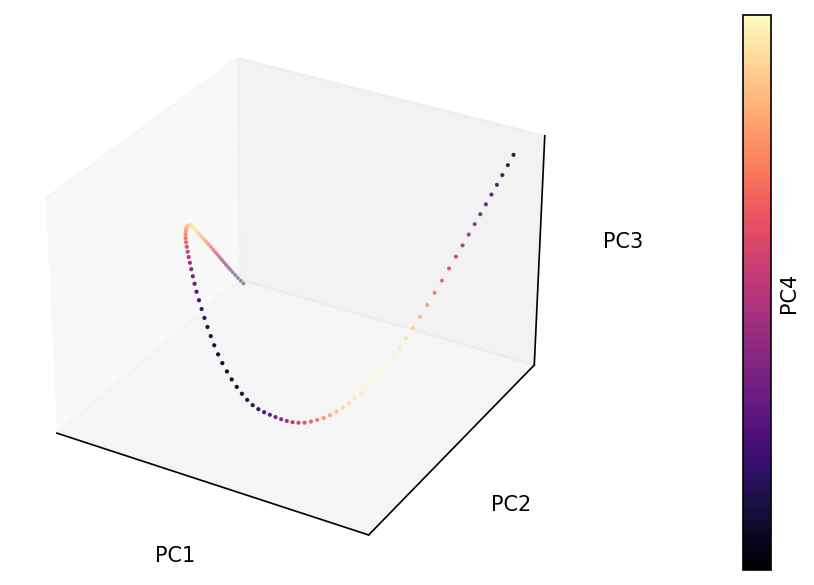

/Users/gregoire/miniconda3/envs/mne/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/gregoire/miniconda3/envs/mne/lib/python3.12/site-packages/matplotlib/transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


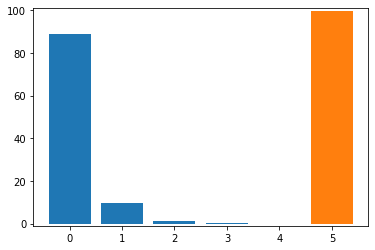

In [473]:

T = 1 # s
dt = 1e-2
num_steps = int(T/dt)

v = np.zeros((num_steps, 2))
v[:, 0] = 1
v[:, 1] = 1

traces, w = simulate_trajectory(v, dt, s_0 = eq_state, **args)
plot_10_frames(traces, dt)

reduced, eigval = simple_4d(traces)

plt.bar([k for k in range(4)], 100*eigval[:4]/np.sum(eigval))
plt.bar(5, 100*eigval[:4].sum()/np.sum(eigval))
plt.ylim(-1, 101)
plt.show()

#### Random movement

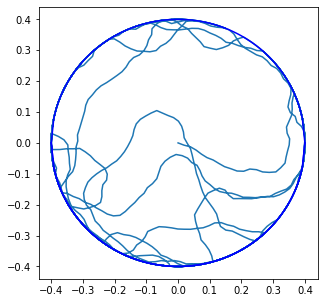

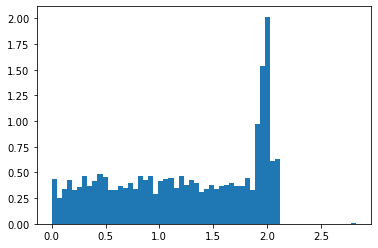

In [196]:
dt = 1e-2
T = 20 # s

def random_trajectory_in_arena(T, dt, radius=1, c = 1, rep = 0, sigma_theta=10, v_norm = 10):
    num_steps = int(T/dt)
    theta = sigma_theta * np.random.randn(num_steps) * dt**0.5
    v = np.zeros((num_steps, 2))/dt
    v[0] = v_norm
    v_orient = 0
    x = np.zeros((num_steps, 2))
    
    for t in range(1, num_steps):
        x_norm = np.linalg.norm(x[t-1])        
        v_orient += theta[t]
        v[t, 0], v[t, 1] = np.cos(v_orient)*v_norm, np.sin(v_orient)*v_norm
        repulsion_mag = rep * np.exp(-c* (x_norm**2))
        
        v[t] += repulsion_mag * x[t-1]/(x_norm + 0.0001)
        v[t] = (np.minimum(np.linalg.norm(x[t-1]+dt*v[t]), radius) * (x[t-1]+dt*v[t])/np.linalg.norm(x[t-1]+dt*v[t]) - x[t-1])/dt
        
        x[t] = x[t-1] + dt*v[t]

    return x, v

r = 0.4

pos, speed= random_trajectory_in_arena(T=T, dt=dt, v_norm = 2, radius = r, rep=0.1, sigma_theta = 3)

plt.figure(figsize=(5, 5))
plt.plot(pos[:, 0], pos[:, 1])
x = np.linspace(-r, r, 100)
plt.plot(x, np.sqrt(r**2-x**2), c='blue')
plt.plot(x, -np.sqrt(r**2-x**2), c='blue')
plt.plot(x, -np.sqrt(r**2-x**2), c='blue')
plt.show()
plt.hist(np.linalg.norm(speed, axis = 1), bins =60, density = True)
plt.show()


In [ ]:
reduced, eigval = simple_4d(traces)

plt.bar([k for k in range(4)], 100*eigval[:4]/np.sum(eigval))
plt.bar(5, 100*eigval[:4].sum()/np.sum(eigval))
plt.ylim(-1, 101)
plt.show()

In [524]:
center_coords , _= blob_center(traces)

  0%|                                                   | 0/250 [00:00<?, ?it/s]/Users/gregoire/miniconda3/envs/mne/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer
100%|███████████████████████████████████████| 250/250 [00:00<00:00, 1118.64it/s]


building matrix...
Solving using rk45


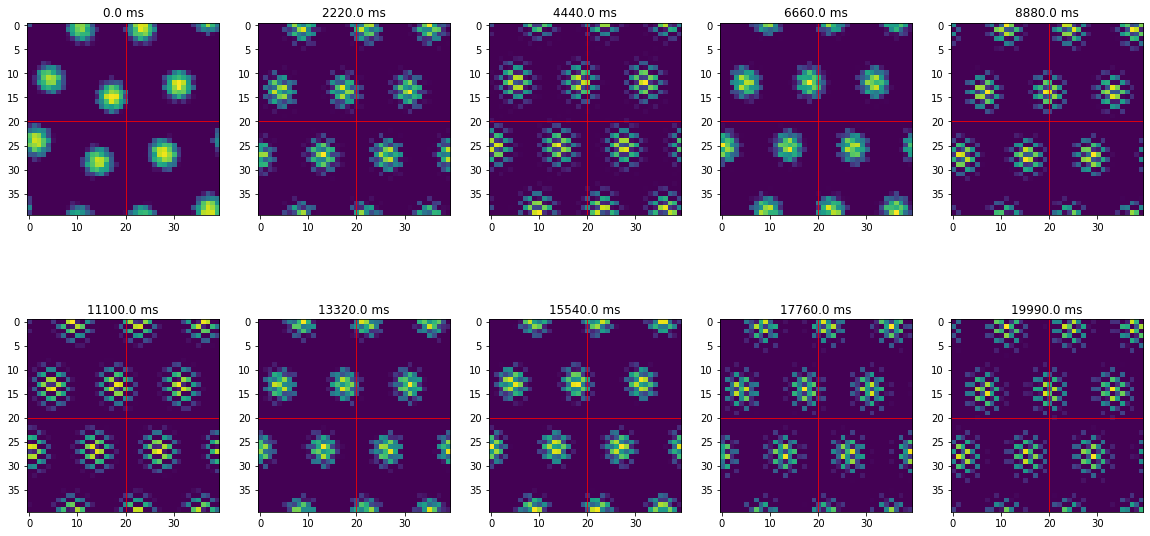

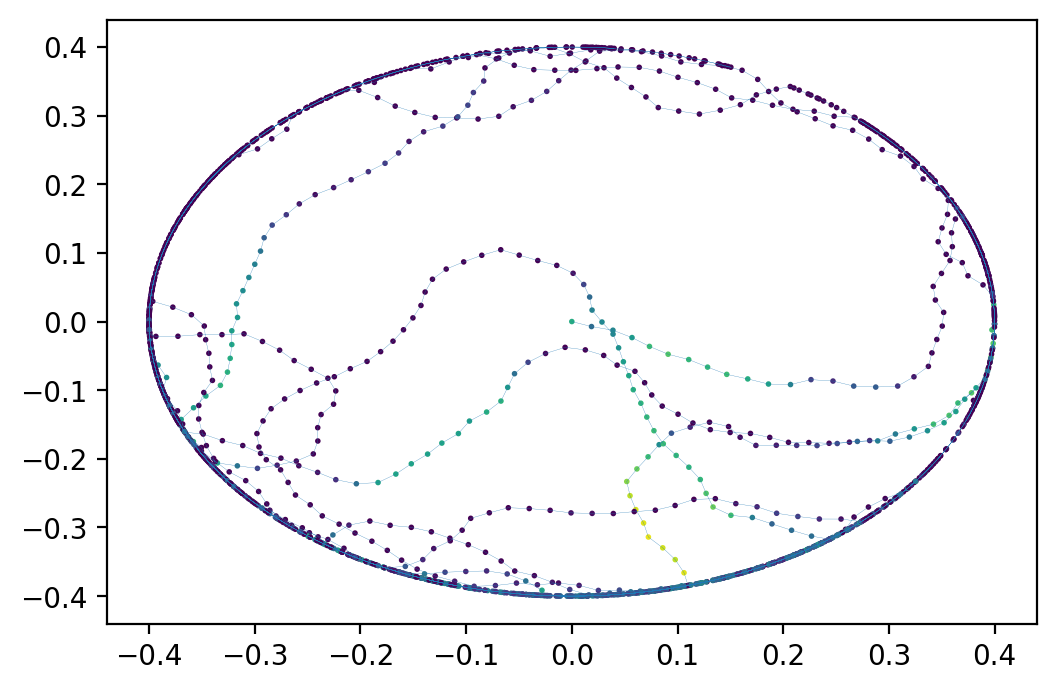

In [197]:
#v_norm = 3
#dt = 5e-4
#num_steps = int(T/dt)
#v = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=num_steps)
#v = v_norm * v/np.linalg.norm(v, axis=1, keepdims=True) + np.array([0.3, 0.3])

trajectory = pos
traces, w = simulate_trajectory(speed, dt, s_0 = eq_state, savepath='data/long_circle2', **args)
# traces = np.load('data/long_circle2.npy')

plot_10_frames(traces, dt)
fig, ax = plt.subplots(dpi = 200)

cell_index = 365

ax.scatter(trajectory[:, 0], trajectory[:, 1], c=traces[:, cell_index], s=1)
ax.plot(trajectory[:, 0], trajectory[:, 1], lw=0.1)

plt.show()

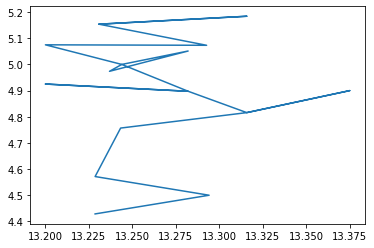

In [520]:
plt.plot(center_coords[:, 0], center_coords[:, 1],)

In [265]:
traces.ndim

2

In [240]:
def integrate_velocity_from_blob(center_coords):
    v = np.diff(center_coords, axis=0)
    return v

v = integrate_velocity_from_blob(center_coords)
speed = np.diff(pos[:10000], 0)

### Idees 

- Entrainer un RNN pour reproduire les propriétés des grid cells, voire si le pattern de connectivité emerge
- Activity manifolds (tore etc) pour periodic vs aperiodic
- Voir si il y a de la phase precession dans le modele

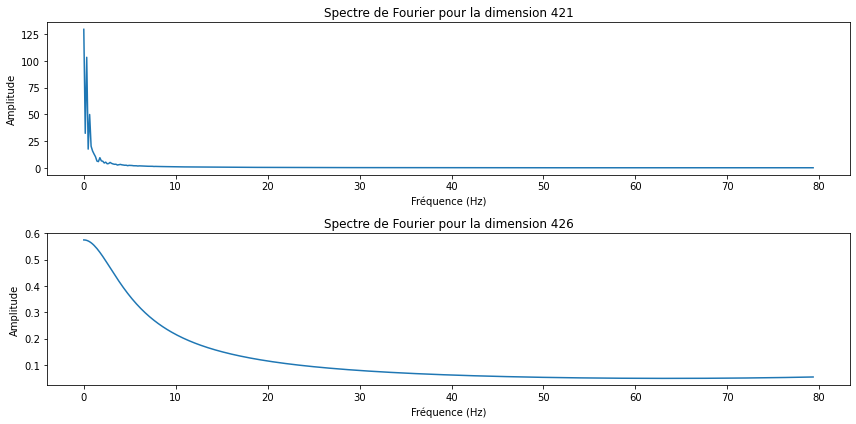

In [721]:
import numpy as np
import matplotlib.pyplot as plt

# Génération d'une série temporelle multidimensionnelle
# Exemple : 2 dimensions (sinusoïde et cosinus)
t = np.linspace(0, 2 * np.pi, 1000)  # Temps
signal_1 = np.sin(2 * np.pi * 5 * t)  # Signal 1 (5 Hz)
signal_2 = np.cos(2 * np.pi * 3 * t)  # Signal 2 (3 Hz)


# Combinaison dans une série temporelle multidimensionnelle
X = traces.T

# Application de la FFT sur chaque dimension
fft_results = np.fft.fft(X, axis=1)  # FFT sur les colonnes

# Fréquences associées
frequencies = np.fft.fftfreq(t.size, d=(t[1] - t[0]))

# Magnitude des coefficients de Fourier
magnitude = np.abs(fft_results)

# Visualisation des coefficients de Fourier pour chaque dimension
plt.figure(figsize=(12, 6))
for j, i in enumerate([420, 425]):
    plt.subplot(2, 1, j + 1)
    plt.plot(frequencies[:t.size // 2], magnitude[i, :t.size // 2])  # Fréquences positives
    plt.title(f"Spectre de Fourier pour la dimension {i + 1}")
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

# Reconstruction d'un signal à partir des coefficients
reconstructed_signal = np.fft.ifft(fft_results, axis=1).real


In [706]:
traces.shape

(800, 1600)